# Lord of the rings 

Now that we know Raphtory is installed and running, let's walk through another example. In this tutorial we will build a graph from two complimentary Lord of the Rings datasets, looking at when characters interact throughout the trilogy 🧝🏻‍♀️🧙🏻‍♂️💍.

This and all following python tutorials are built as iPython notebooks. If you want to follow along on your own machine, click the `show Source` link on the right of this page.

## Let's have a look at the example data

The data we are going to use is two `csv` files which will be pulled from our <a href="https://github.com/Raphtory/Data">Github data repository</a>. These are the structure of the graph (`lotr.csv`) and some metadata about the characters (`lotr_properties.csv`)

For the structure file each line contains two characters that appeared in the same sentence, along with the sentence number, which we will use as a `timestamp`. The first line of the file is `Gandalf,Elrond,33` which tells us that Gandalf and Elrond appears together in sentence 33.

For the properties file each line gives a characters name, their race and gender. For example `Gimli,dwarf,male`.


### Downloading the csv from Github 💾

The following cell will download the csv files and save them in the `tmp` directory on your computer. This will be deleted when you restart your computer, but it's only a couple of KB in any case. If you would like to permanently save these files feel free to change the download location. 



In [2]:
import requests

url_lotr_csv = "https://raw.githubusercontent.com/Raphtory/Data/main/lotr.csv"
url_lotr_properties_csv = "https://raw.githubusercontent.com/Raphtory/Data/main/lotr_properties.csv"

response_lotr_csv = requests.get(url_lotr_csv)
response_lotr_properties_csv = requests.get(url_lotr_properties_csv)
structure_file = "/tmp/lotr.csv"
properties_file = "/tmp/lotr_properties.csv"

if response_lotr_csv.status_code == 200 and response_lotr_properties_csv.status_code == 200:
    with open(structure_file, "wb") as f:
        f.write(response_lotr_csv.content)
    with open(properties_file, "wb") as f:
        f.write(response_lotr_properties_csv.content)
    
    print("****LOTR GRAPH STRUCTURE****")
    with open("/tmp/lotr.csv", "r") as f:
        for _ in range(3):
            print(f.readline().strip())

    print("****LOTR GRAPH PROPERTIES****")
    with open("/tmp/lotr_properties.csv", "r") as f:
        for _ in range(3):
            print(f.readline().strip())
else:
    print("Failed to download data.")


****LOTR GRAPH STRUCTURE****
Gandalf,Elrond,33
Frodo,Bilbo,114
Blanco,Marcho,146
****LOTR GRAPH PROPERTIES****
Aragorn,men,male
Gandalf,ainur,male
Goldberry,ainur,female


## Importing Raphtory and supporting libraries
Now that we have our data we can sort out our imports and create the Raphtory `Graph` which we will ingest it into.

The imports are for parsing CSV files, accessing pandas dataframes, and bringing in all the Raphtory classes we will use in the tutorial.

In [3]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

from raphtory import Graph
from raphtory import algorithms as algos

graph = Graph()

## Adding data directly into the Graph

The simplest way to add data into a graph is to directly call the `add_vertex` and `add_edge` functions, which we saw in the quick start guide. These have required arguments defining the time the addition occurred and an identifier for the entity being updated. These functions, however, have several optional arguments allowing us to add `properties` and `layers` on top of the base structure. You can see full explainations of these within the [Graph API documentation](https://docs.raphtory.com/en/master/api/raphtory.html#raphtory.Graph) 

Lets take a look at this with our example data. In the below code we are opening The Lord of The Rings structural data via the csv reader and looping through each line. 

To insert the data we:

* Extract the two characters names, referring to them as the `source_node` and `destination_node`.
* Extract the sentence number, referring to is as `timestamp`. This is then cast to an `int` as `epoch` timestamps in Raphtory must be a number.
* Call `add_vertex` for both nodes, setting their type to `Character`.
* Create an edge between them via `add_edge` and labelling this a `Co-occurence`.

In [4]:
with open(structure_file, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:

        source_node = row[0]
        destination_node = row[1]
        timestamp = int(row[2])
        
        graph.add_vertex(timestamp=timestamp, id=source_node, properties={"vertex_type": "Character"})
        graph.add_vertex(timestamp=timestamp, id=destination_node, properties={"vertex_type": "Character"})  
        graph.add_edge(timestamp, source_node, destination_node, layer="Character_Co-occurence")

## Let's see if the data has ingested

To do this we can run a query on our graph. As Raphtory allows us to explore the network's history, lets add a bit of this in as well. 

Below we check the earliest timestamp and latest timestamp in the data and see how many vertices and edges there are. 

In [5]:
print("Earliest time: %i" % graph.earliest_time())
print("Latest time: %i" % graph.latest_time())

print("Number of vertices: %i" % graph.num_vertices())
print("Number of edges: %i" % graph.num_edges())

Earliest time: 33
Latest time: 32674
Number of vertices: 139
Number of edges: 701


We can also access a specific vertex, such as `Gandalf`, and see his degree at different points in time using the `at()` function. 

In the first call, we get the entire graph at time 1000, and then check the degree of gandalf. 

In the second call, we get the vertex gandalf, get their instance at time 10,000 and the degree. 

Note: `at()` can be called on the graph OR the vertex - this is the same for all `view` functions which you will see more of later in the tutorials.

In [6]:
print("Gandalf's degree at 1000: %i" % graph.at(1000).vertex("Gandalf").degree())

print("Gandalf's degree at 10,000: %i" % graph.vertex("Gandalf").at(10000).degree())

Gandalf's degree at 1000: 4
Gandalf's degree at 10,000: 26


## Updating graphs, merging datasets and adding properties

One cool thing about Raphtory is that we can freely insert new information at any point in time and it will be automatically inserted in chronological order. This makes it really easy to merge datasets or ingest out of order data. 

A property on a vertex or edge can be either temporal or constant. 

* Constant properties, do not change and are fixed throughout the life of the graph, e.g. the `name` property. 
* Temporal properties can change over time, e.g. `balance` of a bank account. 

All property objects require the user to specify a name and value.

To explore this and to add some properties to our graph, lets load our second dataset!

Below we are opening our property file the same way as the structure file. This data does not have a time element, so we can add the values as constant properties. This means they will be available at every point in time and the values will stay the same. 

Now it's worthwhile noting that we aren't calling a function called `update_vertex` or something similar, even though we know the vertex exists. This is because everything is considered an addition into the history and Raphtory sorts all the ordering internally!

In [7]:
with open(properties_file, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
        graph.add_vertex_properties(row[0], {"race": row[1],"gender": row[2]})


## Using our properties as part of a query
To see if our new properties are included in the graph we can write a new query! Lets have a look at the dwarves who have the most interactions.

To do this we first get the vertices within the graph and check which ones are `dwarves` by getting their property value for `race`. Next we get the edges of each dwarf and call the `explode()` function, which expands the `temporal edges` (storing all updates) into individual edges, one per update. E.g. if Gimli and Balin met four times, in the graph they have one edge between them, but if we explode this edge, we can see each time they met.  

Finally, we can sort the data within a pandas dataframe to see **Gimli** has by far the most!

In [8]:
result = []

for vertex in graph.vertices():
    if vertex.properties.get("race") == "dwarf":
        interactions = len(vertex.edges().explode())
        latest = vertex.latest_time()
        result.append({"timestamp": latest, "name": vertex.name(), "interactions": interactions})

pd.DataFrame(result).sort_values(by="interactions",ascending=False)

,timestamp,name,interactions
3,31247,Gimli,185
1,31129,Glóin,31
2,10938,Balin,14
0,9605,Thorin,5


## Running built in algorithms

As the final step within this tutorial, we can explore some of Raphtory's built in algorithms. We have implemented many of the standard algorithms you may expect within a graph library, such as `Connected Components` and `PageRank`, but Raphtory also has several temporal algorithms such as `Temporal Reachability` and `Temporal Motifs`. You can check out the full available list [here](https://docs.raphtory.com/en/master/api/raphtory.html#module-raphtory.algorithms) and edit the code below to test them all.

For this demonstration we shall focus just on `PageRank` and look at how Gandaf's importance changes over the history of our graph by splitting the network into 1000 sentence snapshots and running the algorithm on each one.

To do this we first define a `rolling window` over the graph which will create an iterator of `windowed graphs` which only include nodes and edges updated within their window period (1000 sentences).  Before looping through these we can grab the first two snapshots to look at how the `start` and `end` of their windows line up.  

All algorithms in Raphtory return a [AlgorithmResult](https://docs.raphtory.com/en/master/api/raphtory.html#raphtory.AlgorithmResultStrU64) which has functions for sorting, grouping, top_k and convertion to dataframes. In the code below we use this API to extract Gandalfs score for each 1000 sentances and record it alongside the earliest timestamp in the window, which can the be plotted via matplotlib.



The first windowed graph contains updates between 33 and 1033
The second windowed graph contains updates between 1033 and 2033


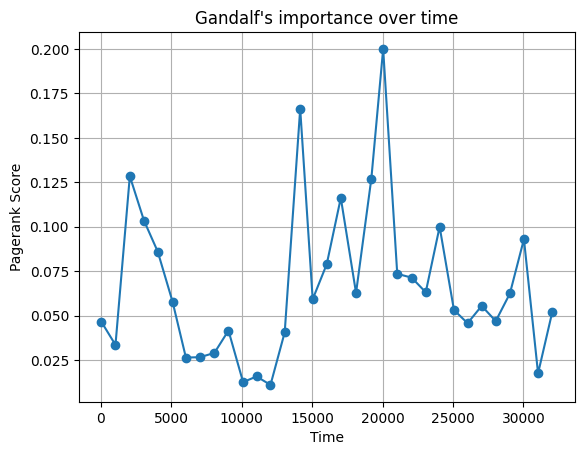

In [19]:
importance = []
time = []
snapshots = graph.rolling(window=1000)
example_windowed_graph_1=list(snapshots)[0]
example_windowed_graph_2=list(snapshots)[1]
print("The first windowed graph contains updates between",example_windowed_graph.start(),"and",example_windowed_graph.end())
print("The second windowed graph contains updates between",example_windowed_graph_2.start(),"and",example_windowed_graph_2.end())

for windowed_graph in snapshots:
    result =algos.pagerank(windowed_graph)
    importance.append(result.get("Gandalf"))
    time.append(windowed_graph.earliest_time())

plt.plot(time, importance, marker='o')
plt.xlabel('Time')
plt.ylabel('Pagerank Score')
plt.title("Gandalf's importance over time")
plt.grid(True)
plt.show()    